# Comment on the results for points (4), (5)

### 4. find two observations in the data set, such that they have different CP profiles (e.g. model response is growing with age for one observations and lowering with age for another). Note that you need to have model with interactions to have such differences

I've used random forest as a model for predicting house prices and chosen 2 significantly different houses to inspect their CP profiles. One was priced at \\$618k (ground truth) and the other, much larger and with great view, at ~\\$1.4M.

|       |   sqft_living |   sqft_lot |   view |   condition |   grade |   predicted_price |   actual_price |
|------:|--------------:|-----------:|-------:|------------:|--------:|------------------:|---------------:|
| 18659 |          1890 |       4700 |      0 |           4 |       7 |   658314          |   618000       |
| 11268 |          3700 |       7920 |      4 |           3 |       9 |        1.8212e+06 |        1.4e+06 |

CP profiles for `sqft_living` (living space area) and `sqft_lot` variables for these observations look like this:

![alt text](rf_sqft_living.png "Title")
![alt text](rf_sqft_lot.png "Title")

Large variability and seemingly random ups and downs might indicate the overfitting of the model, altough this kind of 'discreteness'/ lack of smoothness is somewhat expected from the random forest model.

Given the chosen training features, it was not easy to find observations that had significantly different CP profiles. Pretty much for all of them (unsurprisingly) the higher the value, the higher the price. However there was something unexpected happening with CP profiles for `sqt_lot` variable (total land area) at the lower values, and this is where the CP profiles between two observations differed the most.

We can see that for the larger house, in the beginning, CP profile decreases, which is not really observed for the smaller house. Since `sqft_living` is linked to `sqft_lot`, it might be the case that combining such a small lot values and fairly large living area simply won't ever happen - the problem of out of distribution data.

Another example where profiles differ (slightly) is `condition` variable:
![alt text](rf_condition.png "Title")

Strangely, for the larger house, price slightly decreases with better condition, as opposed to a smaller house. It might be just a noise in the dataset/model, or maybe some weak indirect correlations like worse condition -> older age -> more prestigious building / better location. 

### 5. train a second model (of any class, neural nets, linear, other boosting) and find an observation for which CP profiles are different between the models

As a second model I've trained linear regression model. Unsurprisingly, CP profiles for them are linear and thus different from the RF model CP profiles.

One of the interesting examples is the profile for `sqft_lot`. 

![alt text](lin_sqft_lot.png)

The larger the lot size, the smaller predicted price. My first thought was that, given that 'living area' is fixed, as we increase total land area there is less space for living. But linear model 'do not have' interactions - and thus is not flexible enough to take that into account. 

Another hypothesis is that, in general across the dataset, smaller lots were correlated with better location which would explain higher prices.

Another slight deviation can be observed in the profile of the `grade` variable.

Profile for the linear model:
![alt text](lin_grade.png)

Profile for the rf model:
![alt text](rf_grade.png)

RF model seemed to have learnt that for the lower values, grade does not matter as much. This couldn't have been captured by a linear model.

# Appendix

In [1]:
import shap
import pandas as pd
import seaborn as sns

### Data loading & basic inspection

In [2]:
df = pd.read_csv(('kc_house_data.csv'))
print("number of rows:", df.shape[0])
df.sample(3)

number of rows: 21613


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
14931,3013300895,20140718T000000,337000.0,2,1.00,1010,4000,1.0,0,0,...,7,1010,0,1947,0,98136,47.5311,-122.382,1480,4366
5864,4141800285,20140714T000000,1727000.0,4,2.25,3470,8000,1.5,0,1,...,9,2360,1110,1906,2002,98122,47.6149,-122.287,3010,8000
14691,1025059186,20140917T000000,438000.0,3,1.75,1990,9885,1.0,0,0,...,7,1030,960,1978,0,98052,47.6722,-122.162,1560,10000


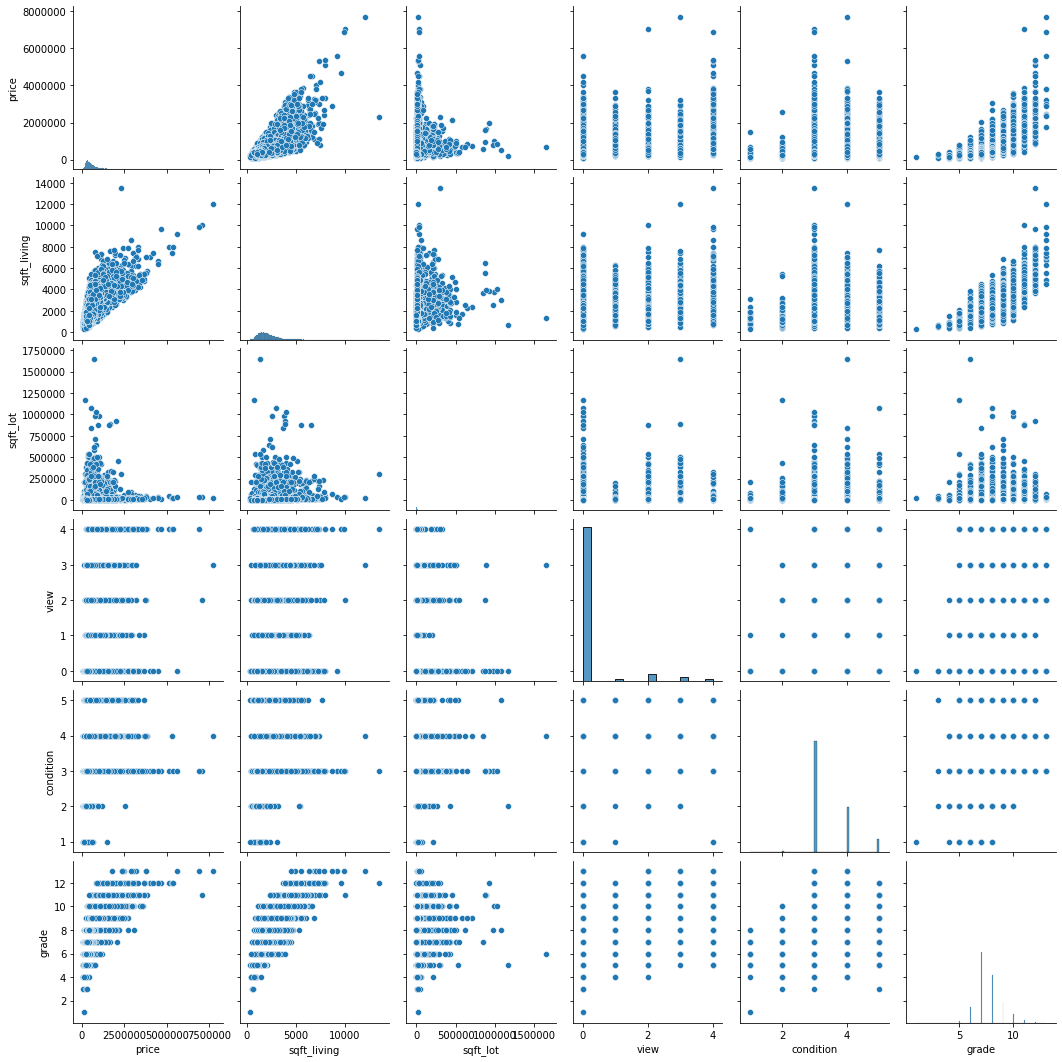

In [3]:
COLS = ["price", "sqft_living", "sqft_lot", "view", "condition", "grade"]
sns.pairplot(df[COLS])

### 1.For the selected data set, train at least one tree-based ensemble model (random forest, gbm, catboost or any other boosting)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_COLS = ["sqft_living", "sqft_lot", "view", "condition", "grade"]

X, y = df[X_COLS], df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
rf = RandomForestRegressor(random_state=0, n_jobs=-1).fit(X_train, y_train)

### 2. for some selected observation from this dataset, calculate the model predictions for model (1)

In [5]:
SAMPLE_SIZE = 2
SEED = 6

X_test_sample = X_test.sample(SAMPLE_SIZE, random_state=SEED)
y_test_sample = y_test[X_test_sample.index]

test_sample = X_test_sample.copy()
test_sample['predicted_price'] = rf.predict(test_sample)
test_sample['actual_price'] = y_test_sample
print(test_sample.to_markdown())

|       |   sqft_living |   sqft_lot |   view |   condition |   grade |   predicted_price |   actual_price |
|------:|--------------:|-----------:|-------:|------------:|--------:|------------------:|---------------:|
| 18659 |          1890 |       4700 |      0 |           4 |       7 |   658314          |   618000       |
| 11268 |          3700 |       7920 |      4 |           3 |       9 |        1.8212e+06 |        1.4e+06 |


### 3. For an observation selected in (2), calculate the decomposition of model prediction using Ceteris paribus / ICE profiles (packages for R: DALEX, ALEPlot, packages for python: AIX360, pyCeterisParibus, PDPbox, own code). 

### 4. Find two observations in the data set, such that they have different CP profiles (e.g. model response is growing with age for one observations and lowering with age for another). Note that you need to have model with interactions to have such differences

In [6]:
!pip install pyCeterisParibus

In [7]:
from ceteris_paribus.explainer import explain
from ceteris_paribus.profiles import individual_variable_profile
from ceteris_paribus.plots.plots import plot, plot_notebook

explainer_rf = explain(rf, data=X, y=y, label='Random Forest', variable_names=X.columns.tolist())
cp_rf = individual_variable_profile(explainer_rf, X_test_sample)
# plotting profiles one by one, as figure with all the plots with respective variables 
# plotted at once did not work properly  
for feature in X_test_sample.columns:
    plot_notebook(cp_rf, selected_variables=[feature], height=600, width=800)

### 5. train a second model (of any class, neural nets, linear, other boosting) and find an observation for which CP profiles are different between the models

In [8]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)

explainer_lin = explain(lin, data=X, y=y, label='Linear regression', variable_names=X.columns.tolist())
cp_lin = individual_variable_profile(explainer_lin, X_test_sample, y_test_sample.values)
# plotting profiles one by one, as figure with all the plots with respective variables 
# plotted at once did not work properly  
for feature in X_test_sample.columns:
    plot_notebook(cp_lin, selected_variables=[feature], height=600, width=800)